In [162]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from data_creation import create_dataset, torch_parameter_structure
from torch_geometric.utils import dense_to_sparse

In [ ]:
def to_pyg_data(x_train, y_train, ode_dim, n_data):
    # distribute x_train values as node features
    x = torch.zeros([ode_dim, 2*n_data])

    k = 0
    for j in range(0,2*n_data):
        for i in range(0,ode_dim):
            x[i,j] = x_train[k]
            k += 1

    # build edge indices (assuming fully connected network)
    adj_matrix = torch.ones((ode_dim, ode_dim))
    edge_index, _ = dense_to_sparse(adj_matrix)

    # distribute weights as edge attributes 
    edge_attr = torch.zeros([len(edge_index.t()),1])
    weights  = torch.reshape(x_train[k:],[ode_dim,ode_dim])

    k = 0
    for i in range(0,ode_dim):
        for j in range(0,ode_dim):
                edge_attr[k,0] = weights[i,j]
                k += 1

    y = y_train

    data = Data(x=x,edge_index=edge_index,edge_attr=edge_attr,y=y)

    return data

ode_dim = 2
n_data = 2
x_exact, x_train, y_train, param = create_dataset(ode_dim,n_data,100)

dataset = []
for i in range(0,len(x_train)):
    dataset.append(to_pyg_data(x_train[i],y_train[i],ode_dim,n_data))

loader = DataLoader(dataset,batch_size=32,shuffle=True)

x_text_exact, x_test, y_test, param_test = create_dataset(ode_dim,n_data,128)

dataset = []
for i in range(0,len(x_test)):
    dataset.append(to_pyg_data(x_test[i],y_test[i],ode_dim,n_data))

test_loader = DataLoader(dataset,batch_size=128,shuffle=True)


[Data(x=[2, 4], edge_index=[2, 4], edge_attr=[4, 1], y=[4]), Data(x=[2, 4], edge_index=[2, 4], edge_attr=[4, 1], y=[4]), Data(x=[2, 4], edge_index=[2, 4], edge_attr=[4, 1], y=[4]), Data(x=[2, 4], edge_index=[2, 4], edge_attr=[4, 1], y=[4]), Data(x=[2, 4], edge_index=[2, 4], edge_attr=[4, 1], y=[4]), Data(x=[2, 4], edge_index=[2, 4], edge_attr=[4, 1], y=[4]), Data(x=[2, 4], edge_index=[2, 4], edge_attr=[4, 1], y=[4]), Data(x=[2, 4], edge_index=[2, 4], edge_attr=[4, 1], y=[4]), Data(x=[2, 4], edge_index=[2, 4], edge_attr=[4, 1], y=[4]), Data(x=[2, 4], edge_index=[2, 4], edge_attr=[4, 1], y=[4]), Data(x=[2, 4], edge_index=[2, 4], edge_attr=[4, 1], y=[4]), Data(x=[2, 4], edge_index=[2, 4], edge_attr=[4, 1], y=[4]), Data(x=[2, 4], edge_index=[2, 4], edge_attr=[4, 1], y=[4]), Data(x=[2, 4], edge_index=[2, 4], edge_attr=[4, 1], y=[4]), Data(x=[2, 4], edge_index=[2, 4], edge_attr=[4, 1], y=[4]), Data(x=[2, 4], edge_index=[2, 4], edge_attr=[4, 1], y=[4]), Data(x=[2, 4], edge_index=[2, 4], edge_

In [215]:
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, softmax
import torch.nn.functional as F
from torch.nn import Linear, Parameter

class EdgeGAT(MessagePassing):
    def __init__(self, input_size, output_size, no_edge_attributes):
        super(EdgeGAT, self).__init__(aggr='add')

        self.feature_linear = Linear(input_size, output_size)
        self.edge_linear = Linear(no_edge_attributes, output_size)
        self.edge_linear_scalar = Linear(output_size, 1)

        # Attention weights for the source and target nodes
        self.attn_src = Parameter(torch.Tensor(output_size, 1))
        self.attn_tgt = Parameter(torch.Tensor(output_size, 1))

        # Reset parameters (initialize weights)
        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.feature_linear.weight)
        torch.nn.init.xavier_uniform_(self.edge_linear.weight)
        torch.nn.init.xavier_uniform_(self.attn_src)
        torch.nn.init.xavier_uniform_(self.attn_tgt)  

    def forward(self, x, edge_index, edge_attr):

        # edge_index, edge_attr = add_self_loops(edge_index, edge_attr, fill_value=0, num_nodes=x.size(0))

        x = self.feature_linear(x)

        edge_attr = self.edge_linear_scalar(self.edge_linear(edge_attr))

        return self.propagate(edge_index, x=x, edge_attr = edge_attr)
    
    def message(self, x_j, x_i, edge_attr, index):
        alpha = (x_i @ self.attn_src + x_j @ self.attn_tgt + edge_attr).squeeze(-1)
        alpha = F.leaky_relu(alpha, 0.2)

        # Normalize attention coefficients across all neighbors
        alpha = softmax(alpha, index)
        return x_j * alpha.view(-1, 1)


In [216]:
from torch_geometric.nn import global_mean_pool

class EdgeGATNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, edge_attr_dim):
        super(EdgeGATNet, self).__init__()
        self.conv1 = EdgeGAT(in_channels, hidden_channels, edge_attr_dim)
        self.conv2 = EdgeGAT(hidden_channels, out_channels, edge_attr_dim)
        self.lin = Linear(out_channels, out_channels)

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        # First GAT layer with edge features
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)

        # Second GAT layer with edge features
        x = F.relu(self.conv2(x, edge_index, edge_attr))

        # Global mean pooling (assuming a graph-level task)
        x = global_mean_pool(x, batch)

        # Final linear layer (classification or regression task)
        x = self.lin(x)
        return x

In [217]:
from torch.optim import Adam

model = EdgeGATNet(2*n_data, 10, ode_dim ** 2, 1)
optimizer = Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()  # or MSELoss for regression

train_loss = []
test_loss = []

# Training loop
for epoch in range(1000):
    model.train()
    for data in loader:
        optimizer.zero_grad()
        out = model(data)
        
        loss = criterion(out.flatten(), data.y)
        train_loss.append(loss)

        loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        for data in test_loader:
            out = model(data)
            loss = criterion(out.flatten(), data.y)
            print(loss.item())
            test_loss.append(loss)

1.834151029586792
1.778496503829956
1.7258574962615967
1.6755893230438232
1.628248929977417
1.5829330682754517
1.5392791032791138
1.4972848892211914
1.4581186771392822
1.4222825765609741
1.3895635604858398
1.359236717224121
1.3330117464065552
1.3111799955368042
1.2937963008880615
1.27829909324646
1.2642135620117188
1.2509042024612427
1.2389488220214844
1.2280300855636597
1.218845248222351
1.2101141214370728
1.201972484588623
1.19471275806427
1.1874257326126099
1.1794520616531372
1.1725709438323975
1.1665078401565552
1.1608036756515503
1.155690312385559
1.1510096788406372
1.1464577913284302
1.1422377824783325
1.1382858753204346
1.134703278541565
1.1312172412872314
1.1276283264160156
1.1241286993026733
1.1210944652557373
1.1180154085159302
1.114795207977295
1.111596941947937
1.1081761121749878
1.1052641868591309
1.1026742458343506
1.1003165245056152
1.0983350276947021
1.0967938899993896
1.0947171449661255
1.0926300287246704
1.0905929803848267
1.088384985923767
1.0863486528396606
1.084805

KeyboardInterrupt: 

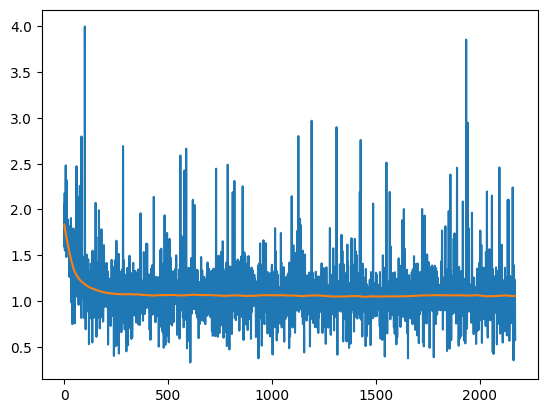

In [218]:
import matplotlib.pyplot as plt
tr_l = [train_loss[i].to('cpu').detach().numpy() for i in range(0,len(train_loss))]
tst_l = [test_loss[i].to('cpu').detach().numpy() for i in range(0,len(test_loss))]
plt.plot(range(0,len(tr_l)),tr_l)
plt.plot(range(0,len(loader)*len(tst_l),len(loader)),tst_l)
plt.show()

In [219]:
def get_adjacency(W):
        values_log_W = torch.sort(torch.log(torch.abs(W.flatten())))[0]
        treshold = values_log_W[torch.sort(values_log_W[1:] - values_log_W[:-1])[1][-1] + 1]
        W_bool_activation = (W >= torch.exp(treshold)).double()
        W_bool_repr = (W <= -torch.exp(treshold)).double()
        A = W_bool_activation-W_bool_repr
        return A

In [220]:
x_val_exact, x_val, y_val, param_val = create_dataset(ode_dim,n_data,1000)

val_dataset = []

for i in range(0,len(x_val)):
    val_dataset.append(to_pyg_data(x_val[i],y_val[i],ode_dim,n_data))

val_loader = DataLoader(val_dataset)

correct = 0
init_correct = 0
total = 0
elem_wise = 0
elem_wise_init = 0
elems_total = 0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
k = 0
for batch in val_loader:
    Ahat = get_adjacency(model(batch))[0]
    A = get_adjacency(batch.y)
    if sum(abs(Ahat-A)) < 0.001:
            correct = correct+1
    total = total + 1
    Ainit = get_adjacency(y_val[k])

    if sum(abs(Ainit-A)) < 0.001:
        init_correct = init_correct+1

    for i in range(0,len(A)):
        
        if abs(Ainit[i]-A[i]) < 0.001:
             elem_wise_init += 1

        if abs(Ahat[i]-A[i]) < 0.001:
             elem_wise += 1
            
        elems_total += 1

print(correct/total)
print(init_correct/total)
print(elem_wise/elems_total)
print(elem_wise_init/elems_total)

0.101
0.093
0.4915
0.5285
